In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

recentdate=session.query(func.max(Measurement.date)).first()
recentdate

('2017-08-23')

In [10]:
p=session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > '2016-08-22').all()

datePrcp_df=pd.DataFrame(data=p,columns=["date","prcp"])
dategroupPrcp=datePrcp_df.groupby(["date"]).mean()
dategroupPrcp=dategroupPrcp.reset_index()
dategroupPrcp=dategroupPrcp.sort_values(by="date",ascending=True)

dategroupPrcp.to_csv("outputs/average_prcp.csv",
                  encoding="utf-8", index=False, header=True)



dategroupPrcp

,date,prcp
0,2016-08-23,0.451667
1,2016-08-24,1.555000
2,2016-08-25,0.077143
3,2016-08-26,0.016667
4,2016-08-27,0.064000
...,...,...
361,2017-08-19,0.030000
362,2017-08-20,0.005000
363,2017-08-21,0.193333
364,2017-08-22,0.166667


In [11]:
listDate=dategroupPrcp["date"].tolist()
listPrcp=dategroupPrcp["prcp"].tolist()

In [12]:
dateList=dategroupPrcp["date"].tolist()
ex_dt=[]
for dt in range(0,len(dateList)):
    if dt%15==0:
        ex_dt.append(dateList[dt])

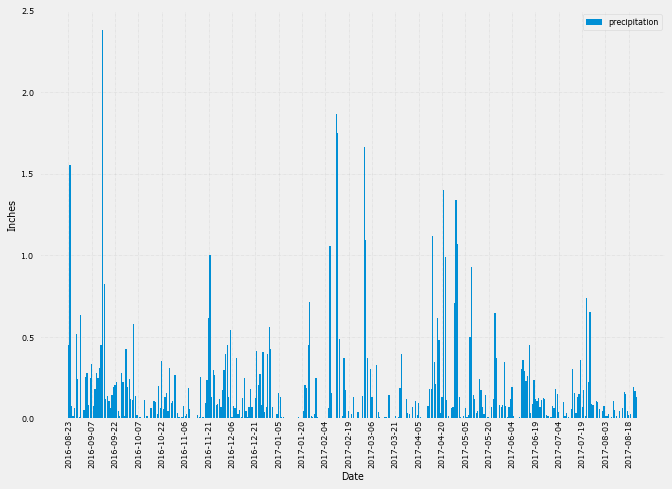

In [13]:
#plt.figure()
#plt.plot(listDate,listPrcp)

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Verdana']
rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=(10,7))

ax.bar(listDate, listPrcp, label="precipitation")
plt.legend(loc="upper right")
plt.xlabel("Date")
plt.ylabel("Inches")
ax.xaxis.set_tick_params(pad=1)
ax.yaxis.set_tick_params(pad=5)
plt.xticks(ex_dt, rotation='vertical')
plt.yticks([0.0,0.5,1.0,1.5,2.0,2.5])
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)
#plt.grid(True, linewidth= 1, linestyle="--")


plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
dategroupPrcp.describe()

,prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
stations=session.query(func.count(Station.station)).all()
stations

[(9)]

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data 
#for this station and plot the results as a histogram

twelwe_month_temperature=session.query(Measurement.date,func.avg(Measurement.tobs))\
                                .filter(Measurement.date>'2016-08-22')\
                                .filter(Measurement.station=="USC00519281")\
                                .group_by(Measurement.date)

df=pd.DataFrame(data=twelwe_month_temperature,columns=["date","temperature"])
df.set_index('date',inplace=True)
df

,temperature
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


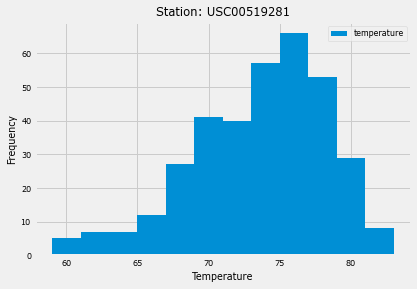

In [21]:
df.plot(kind='hist',bins=12)
plt.title("Station: USC00519281")
plt.xlabel("Temperature")
plt.savefig("outputs/temperature_frequencies_active_station.png")
plt.show()

In [23]:
df=df.reset_index()
df['date']=pd.to_datetime(df['date'])
df

,index,date,temperature
0,0,2016-08-23,77.0
1,1,2016-08-24,77.0
2,2,2016-08-25,80.0
3,3,2016-08-26,80.0
4,4,2016-08-27,75.0
...,...,...,...
347,347,2017-08-14,77.0
348,348,2017-08-15,77.0
349,349,2017-08-16,76.0
350,350,2017-08-17,76.0


In [25]:
df["month"]=df['date'].dt.month
df.to_csv("outputs/last_year.csv",
                  encoding="utf-8", index=False, header=True)
df

,index,date,temperature,month
0,0,2016-08-23,77.0,8
1,1,2016-08-24,77.0,8
2,2,2016-08-25,80.0,8
3,3,2016-08-26,80.0,8
4,4,2016-08-27,75.0,8
...,...,...,...,...
347,347,2017-08-14,77.0,8
348,348,2017-08-15,77.0,8
349,349,2017-08-16,76.0,8
350,350,2017-08-17,76.0,8


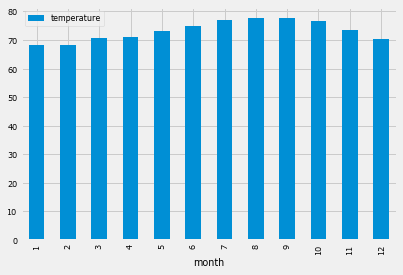

In [26]:
say=df.loc[:,["month","temperature"]].groupby(["month"]).mean()
say.plot(kind='bar')
plt.show()

# Close session

In [27]:
# Close Session
session.close()